分析“如何找出脆弱结点”

In [676]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import torch
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif
import common.utils as utils
from models import model_map
from copy import deepcopy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from itertools import combinations
from scipy.stats import kendalltau
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [917]:
def load_data(dataset, mode="weak_filter"):
    utils.freeze_seed(15)
    stat_data = torch.load(f"./{dataset}-greedy-rbcd-gcn.pth")
    test_mask = stat_data['test_mask']
    stable_mask = stat_data['stable_mask']  # T-T
    frag_mask = stat_data['fragile_mask']   # T-F
    lucky_mask = stat_data['lucky_mask']    # F-T
    fool_mask = stat_data['foolish_mask']   # F-F
    
    X = []
    feature_names = []
    
    for key in stat_data.keys():
        if not key.endswith("mask") and not key.startswith("neighbor") and not key.startswith('logits') and key != 'degree_centrality':
            X.append(stat_data[key])
            feature_names.append(key)
    
    X = torch.stack(X).T
    y = torch.zeros(test_mask.size(0), dtype=torch.long)
    if mode == "weak_filter":
        test_mask = test_mask & (stable_mask | frag_mask)
        y[stable_mask]  = 0
        y[frag_mask]   = 1
    else: 
        y[stable_mask | frag_mask] = 0
        y[lucky_mask | fool_mask] = 1
    X = X[test_mask].numpy()
    y = y[test_mask].numpy()

    
    return X, y, feature_names


In [842]:
cora_data = load_data('cora')
citeseer_data = load_data('citeseer')
cora_ml_data = load_data('cora_ml')
pubmed_data = load_data('pubmed')
sns.set_style("white")
sns.set_palette(sns.color_palette("Blues"))
data_map = {
    'cora': cora_data,
    'citeseer': citeseer_data,
    'cora_ml': cora_ml_data,
    'pubmed': pubmed_data,
}
feature_names = cora_data[2]

In [844]:
def visualize(features, scores, dataset, title=''):
    ax = sns.barplot(x=scores, y=features)
    ax.set(xlabel='Scores', ylabel='Features')
    ax.set_title(f'{title} on {dataset}', fontweight='bold')
    sns.despine(left=True, bottom=True)
    plt.show()
    
def kdeplot(dataset, key, lim=False, xmin=0.0, xmax=1.0):
    data = data_map[dataset]
    X, y, feature_names = data 
    col_index = feature_names.index(key)
    X = X[:, col_index]
    weak_mask = y == 1
    stable_mask = y == 0
    X_weak = X[weak_mask]
    X_stable = X[stable_mask]
    sns.kdeplot(X_weak, label='Weak Nodes', fill=True, thresh=0.05, color='red')
    sns.kdeplot(X_stable, label='Stable Nodes', fill=True, thresh=0.05, color='blue')
    if lim:
        plt.xlim(xmin, xmax)
    plt.xlabel(f"{key}({dataset})")
    plt.legend()
    plt.show()

In [846]:
def anova_analysis(data, k=1):
    X, y, feature_names = data
    fs = SelectKBest(score_func=f_classif, k=k)
    X_selected = fs.fit_transform(X, y)
    scores = fs.scores_
    scores /= np.sum(scores)  # normalize
    return feature_names, list(scores)


def mi_analysis(data, n_bins=20):
    X, y, feature_names = data
    n_col = len(feature_names)
    scores = []
    for col in range(n_col):
        kb = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', random_state=42) 
        X_single = X[:, col].reshape(-1, 1)
        X_dis = kb.fit_transform(X_single)
        mi = mutual_info_classif(X_dis, y, random_state=42)
        scores.append(float(f"{mi.item():.3f}"))
    scores /= np.sum(scores)
    return feature_names, scores

def dtree_analysis(data):
    X, y, feature_names = data
    clf = DecisionTreeClassifier(criterion='log_loss', random_state=42)
    clf.fit(X, y)
    scores = clf.feature_importances_
    scores /= np.sum(scores)  # normalize
    return feature_names, list(scores)

In [847]:

def gen_score_df(dataset):
    data = data_map[dataset]
    feature_names, anova_s = anova_analysis(data)
    _, mi_s = mi_analysis(data)
    _, dtree_s = dtree_analysis(data)

    values = np.array([
        anova_s,
        mi_s, 
        dtree_s,
    ])

    df = pd.DataFrame(values, columns=feature_names, index=["anova score", "mutual information", "dtree importance"], dtype=np.float32)
    return df

In [848]:
gen_score_df("cora")

,degrees,pagerank,clustering_coefficient,eigenvector_centrality,cls_margin
anova score,0.172122,0.106530,0.086542,0.045073,0.589733
mutual information,0.147601,0.140221,0.273063,0.011070,0.428044
dtree importance,0.283384,0.138868,0.020266,0.155823,0.401659


In [849]:
gen_score_df("citeseer")

,degrees,pagerank,clustering_coefficient,eigenvector_centrality,cls_margin
anova score,0.201547,0.096944,0.091168,0.030553,0.579789
mutual information,0.332506,0.081886,0.191067,0.086849,0.307692
dtree importance,0.287073,0.167643,0.003696,0.031375,0.510214


In [850]:
gen_score_df("cora_ml")

,degrees,pagerank,clustering_coefficient,eigenvector_centrality,cls_margin
anova score,0.167391,0.106522,0.186366,0.040676,0.499045
mutual information,0.267516,0.076433,0.299363,0.165605,0.191083
dtree importance,0.089813,0.182277,0.083260,0.144963,0.499686


In [851]:
gen_score_df("pubmed")

,degrees,pagerank,clustering_coefficient,eigenvector_centrality,cls_margin
anova score,0.373399,0.334394,0.010409,0.048686,0.233113
mutual information,0.263301,0.271487,0.092769,0.062756,0.309686
dtree importance,0.167333,0.218126,0.041753,0.048236,0.524551


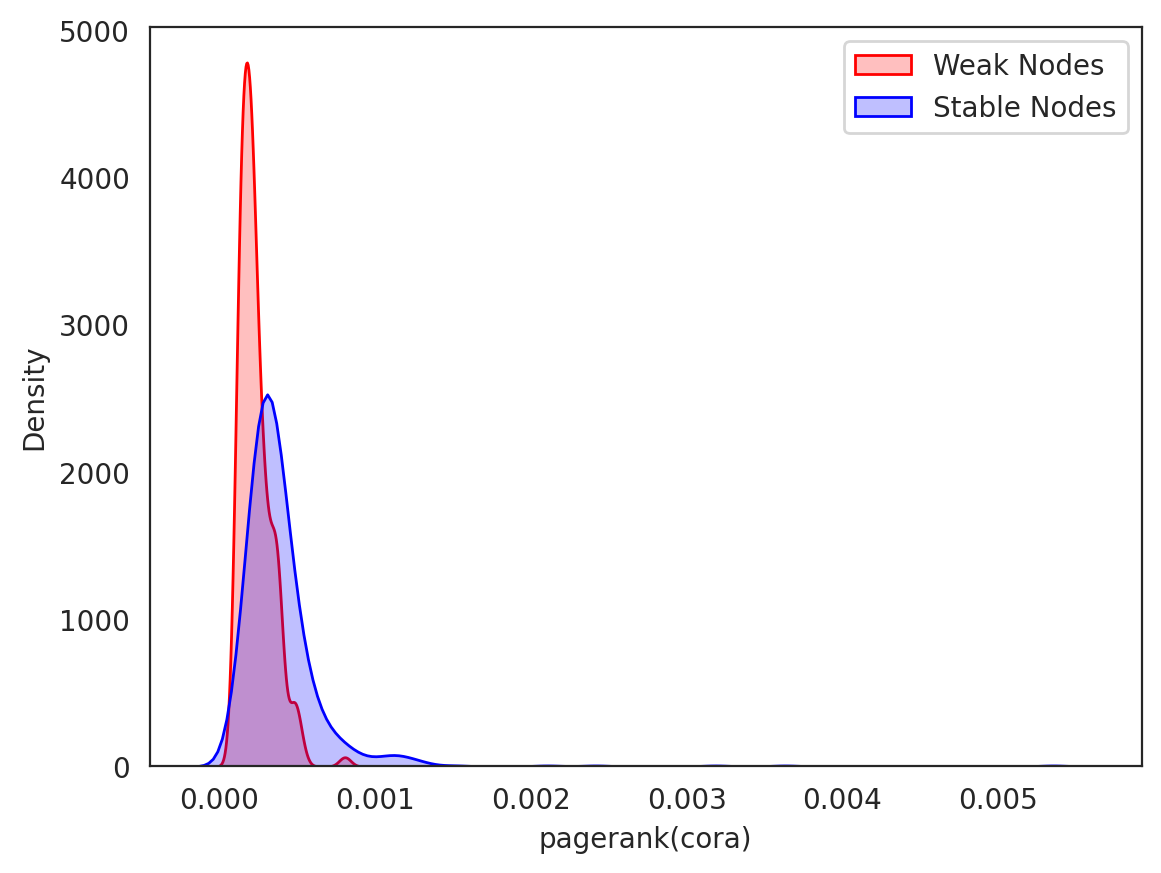

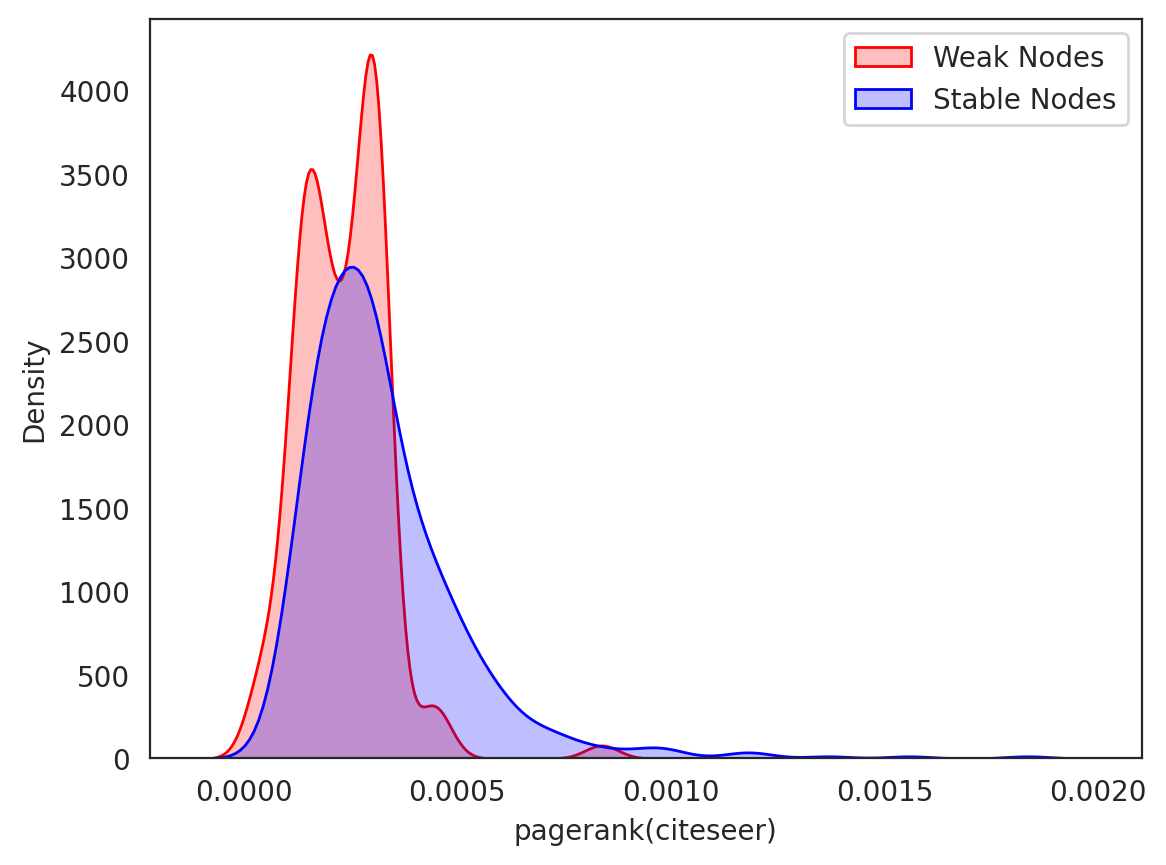

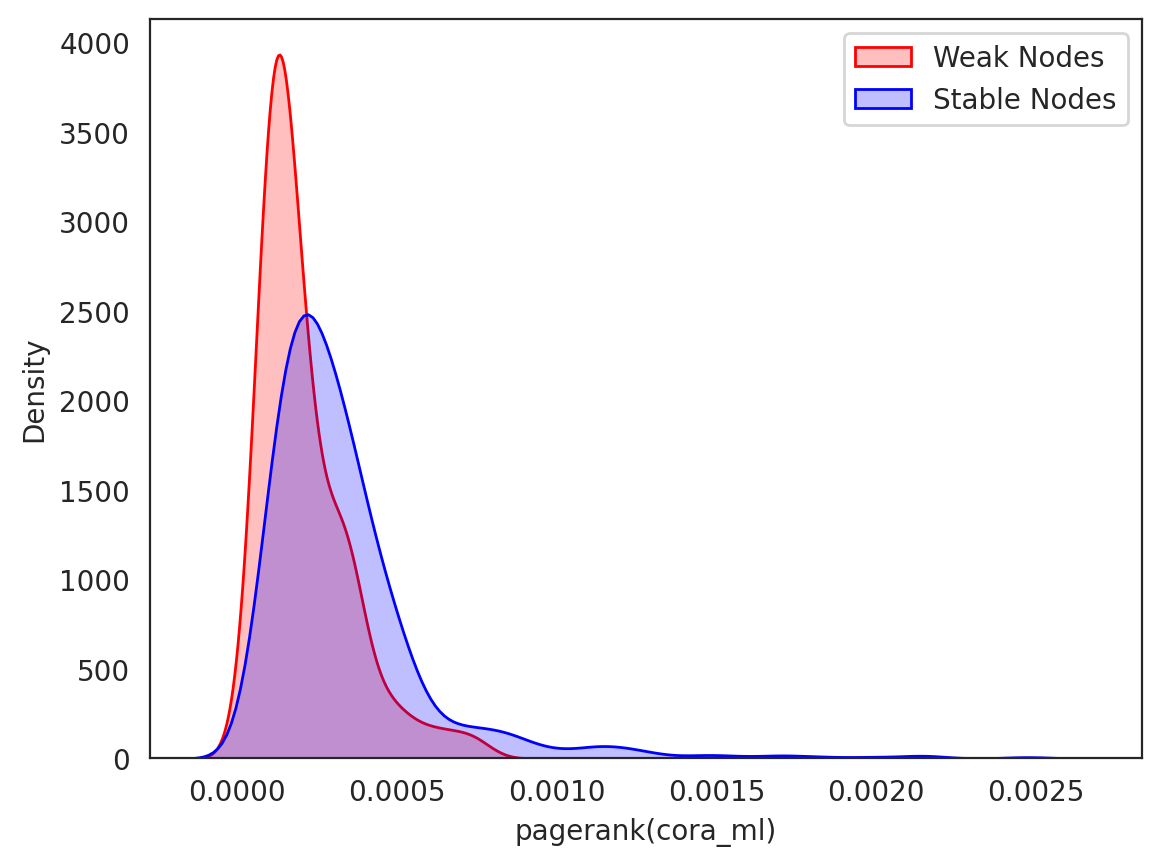

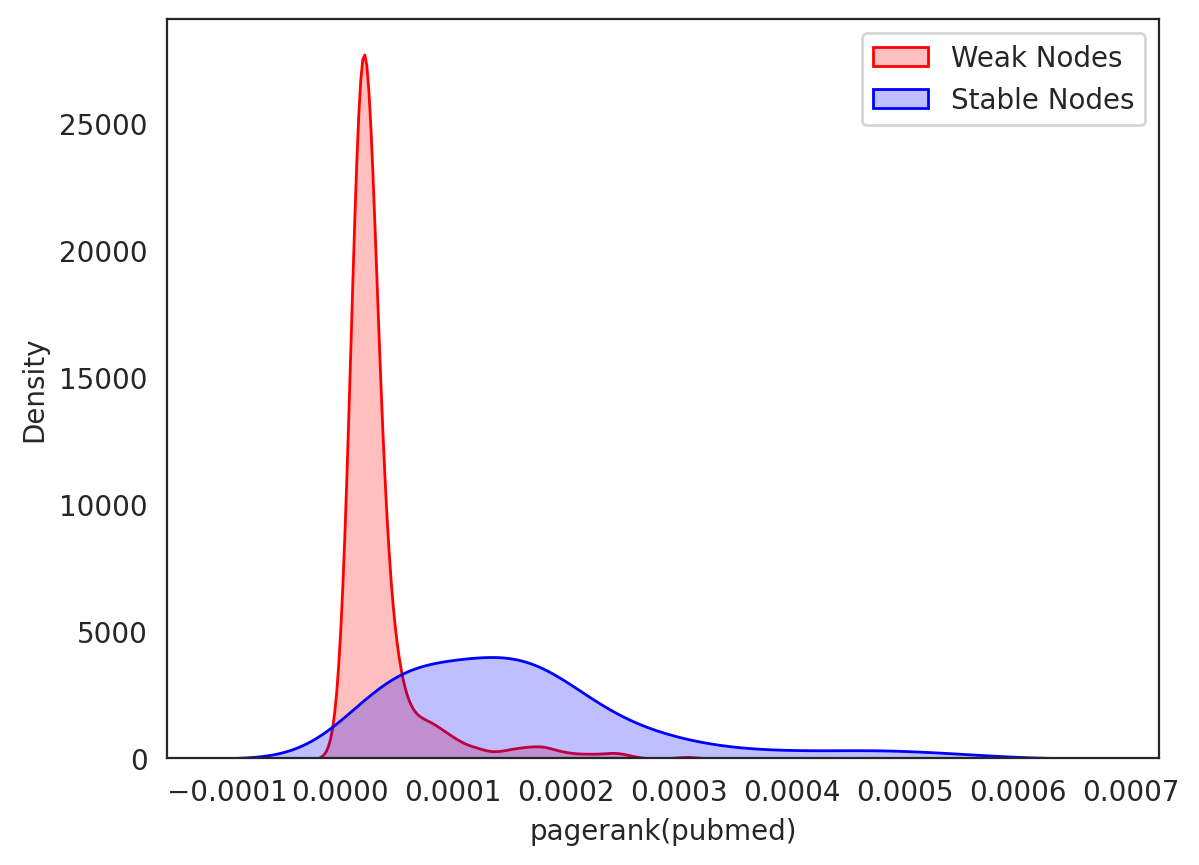

In [852]:
kdeplot("cora", "pagerank")
kdeplot("citeseer", "pagerank")
kdeplot("cora_ml", "pagerank")
kdeplot("pubmed", "pagerank")

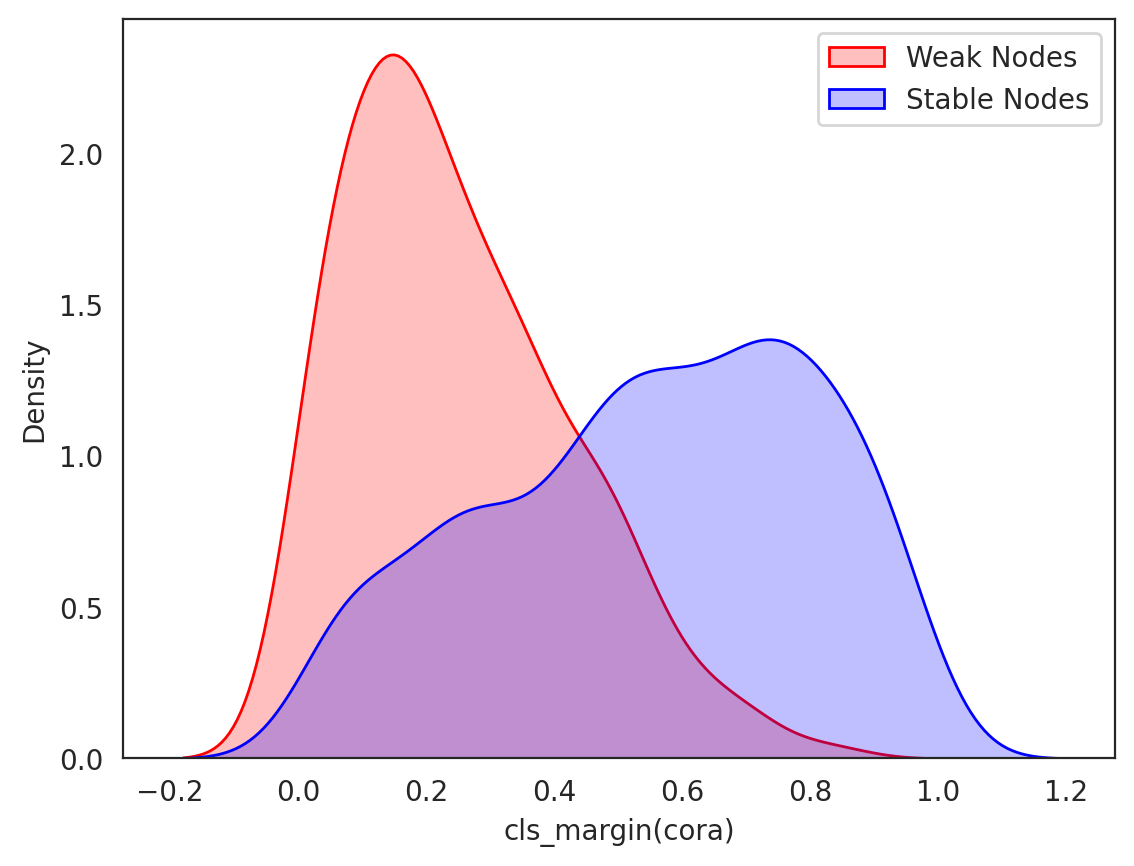

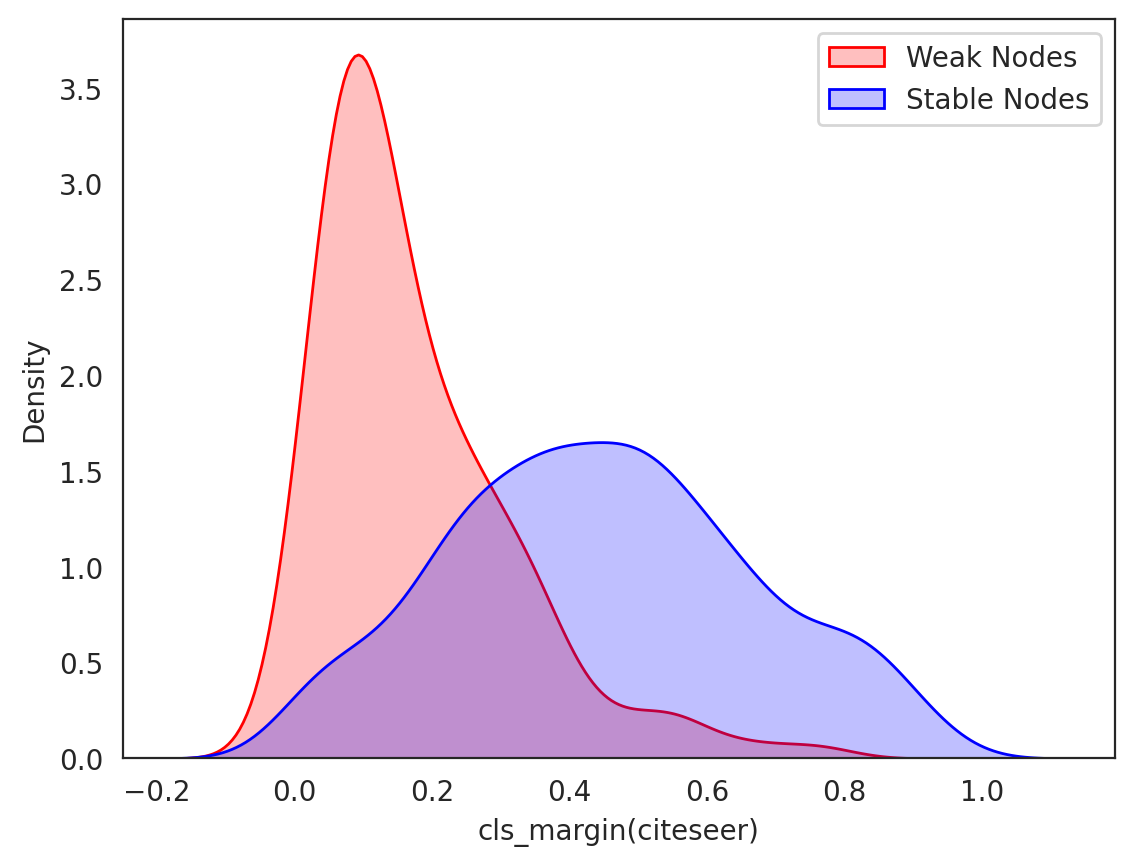

In [853]:
kdeplot("cora", "cls_margin")
kdeplot("citeseer", "cls_margin")

In [854]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



def _evaluate(dataset, features, model, verbose=False, seed=42, normalize=True):
    data = data_map[dataset]
    full_X, y, feature_names = data
    
    X = []
    for name in features:
        col = feature_names.index(name)
        X_ = full_X[:, col].reshape(-1, 1)
        if normalize:
            X_ = (X_ - X_.mean()) / X_.std()
        X.append(X_)
    X = np.concatenate(X, axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
    
    if dataset == 'pubmed':
        sampler = RandomOverSampler
    else:
        sampler = RandomUnderSampler
    ros = sampler(random_state=seed)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    auc = metrics.roc_auc_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred, average=None)[1]  # 获取weak类别的召回率
    f1 = metrics.f1_score(y_test, pred, average=None)[1]
    if verbose:
        print(f"auc={auc:.4f}, recall={recall:.4f}, f1={f1:.4f}")
        print(metrics.classification_report(y_test, pred))
    return auc, recall, f1


def svm(dataset, features, verbose=False):
    clf = SVC(random_state=42)
    return _evaluate(
        dataset=dataset, 
        features=features, 
        model=clf, verbose=verbose, normalize=True)
    
def decision_tree(dataset, features, verbose=False):
    clf = DecisionTreeClassifier(random_state=42)
    return _evaluate(
        dataset=dataset, 
        features=features, 
        model=clf, verbose=verbose, normalize=False)

In [855]:
feature_names

['degrees',
 'pagerank',
 'clustering_coefficient',
 'eigenvector_centrality',
 'cls_margin']

In [856]:
dataset = 'citeseer'

for feat in feature_names:
    svm(dataset, [feat], verbose=True)

auc=0.7513, recall=0.7407, f1=0.4124
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       210
           1       0.29      0.74      0.41        27

    accuracy                           0.76       237
   macro avg       0.62      0.75      0.63       237
weighted avg       0.88      0.76      0.80       237

auc=0.5778, recall=0.8889, f1=0.2341
              precision    recall  f1-score   support

           0       0.95      0.27      0.42       210
           1       0.13      0.89      0.23        27

    accuracy                           0.34       237
   macro avg       0.54      0.58      0.33       237
weighted avg       0.86      0.34      0.40       237

auc=0.6839, recall=0.9630, f1=0.2921
              precision    recall  f1-score   support

           0       0.99      0.40      0.57       210
           1       0.17      0.96      0.29        27

    accuracy                           0.47       237
   macro avg     

In [857]:

def combation_analysis(dataset, score_type='auc', method=svm):
    type_mask = {'auc': 0, 'recall': 1, 'f1': 2}
    n = len(feature_names)
    stats = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(n):
            score = method(dataset, [feature_names[i], feature_names[j]])
            stats[i, j] = float(f"{score[type_mask[score_type]]: .4f}")
    print(stats)

In [923]:
combation_analysis("cora", score_type='auc', method=decision_tree)

[[0.794  0.7212 0.7465 0.7642 0.792 ]
 [0.7212 0.6847 0.7025 0.7164 0.73  ]
 [0.7465 0.7025 0.7135 0.6981 0.7005]
 [0.7642 0.7073 0.6981 0.6473 0.7251]
 [0.792  0.7346 0.7005 0.7251 0.6796]]


In [922]:
combation_analysis("citeseer", score_type='auc', method=decision_tree)

[[0.7513 0.719  0.7513 0.7794 0.8222]
 [0.719  0.669  0.6828 0.7019 0.7024]
 [0.7513 0.6828 0.691  0.7315 0.6952]
 [0.7794 0.7019 0.7315 0.6738 0.7418]
 [0.8222 0.7114 0.6952 0.7418 0.6577]]


In [924]:
combation_analysis("cora_ml", score_type='auc', method=svm)

[[0.7086 0.7046 0.7225 0.6847 0.8005]
 [0.7046 0.6246 0.7026 0.6168 0.7126]
 [0.7225 0.7026 0.6947 0.6768 0.7445]
 [0.6847 0.6168 0.6768 0.5954 0.7189]
 [0.8005 0.7126 0.7445 0.7189 0.7448]]


In [925]:
combation_analysis("pubmed", score_type='auc', method=decision_tree)

[[0.8541 0.7296 0.7678 0.7378 0.9302]
 [0.7296 0.7326 0.6805 0.7349 0.8821]
 [0.7678 0.6805 0.728  0.6519 0.8963]
 [0.7378 0.7372 0.6519 0.6186 0.89  ]
 [0.941  0.9038 0.9071 0.8877 0.859 ]]
